### LibESN - Basic ESN test notebook

##### Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt

sys.path.append(os.path.join(os.path.abspath(""), "../../"))

In [382]:
from LibESN.matrix_generator import matrixGenerator
from LibESN.esn import ESN
from LibESN.esn_fit import ridgeFit, ridgeCV
from LibESN.esn_forecast import forecast, forecastMultistep, forecastDirectMultistep

In [4]:
# ### Deterministic sinusoid data
# data = (
#     np.vstack((
#         0.6 + np.sin(np.linspace(0, 10, 100)),
#         np.cos(np.linspace(0, 10, 100) / 0.6 + 2)
#     )).T,
#     np.vstack((
#         0.6 + np.sin(np.linspace(0.2, 10.2, 100)),
#         np.cos(np.linspace(0.2, 10.2, 100) / 0.6 + 2)
#     )).T
# )

# data_fit_best = data[1]
# data_residuals_best = np.zeros(data[1].shape)

In [74]:
### AR(1) data
def ar(length, alpha, sigma, seed=123456):
    rng = np.random.default_rng(seed)
    eps = rng.standard_normal(size=(length))
    Y = np.zeros((length))
    Y[0] = eps[0]
    for t in range(1, length):
        Y[t] = alpha*Y[t-1] + sigma*eps[t]
    return Y 

Y = np.vstack((
        ar(150, 0.75, 0.2, seed=789),
        ar(150, 0.93, 0.3, seed=191)
    )).T
data_train = (Y[0:101,:], Y[0:101,[1]])
data_test = (Y[101:,:], Y[101:,[1]])

data_train_bfit = Y[0:100,[1]] * 0.9
data_train_minres = Y[1:101,[1]] - data_train_bfit

data_test_bfor = Y[100:-1,[1]] * 0.9

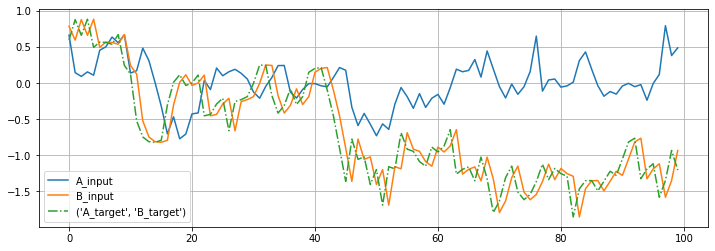

In [42]:
plt.figure(figsize=(12, 4))
plt.plot(data_train[0][0:-1,:], label=("A_input", "B_input")) 
plt.plot(data_train[1][1:,:], label=("A_target", "B_target"), linestyle="dashdot")  
plt.grid()
plt.legend()
plt.show()

In [339]:
A = matrixGenerator((20, 20), dist='sparse_uniform', sparsity=0.2, seed=123)
C = matrixGenerator((20, 2), dist='sparse_uniform', sparsity=0.2, seed=12345)
zeta = 0.0 * matrixGenerator((20, ), seed=123456)
rho = 0.8
gamma = 1
leak = 0.0

esn = ESN(
    None,
    smap=np.tanh, 
    A=A, C=C, zeta=zeta, 
    rho=rho, gamma=gamma, leak=leak
)

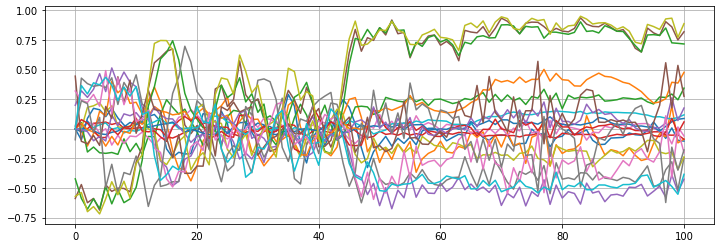

In [340]:
plt.figure(figsize=(12, 4))
plt.plot(esn.states(data_train[0]))  
plt.grid()
plt.show()

##### One-step fit

In [457]:
fit = esn.fit(data_train, ridgeFit(0.01), step=1)

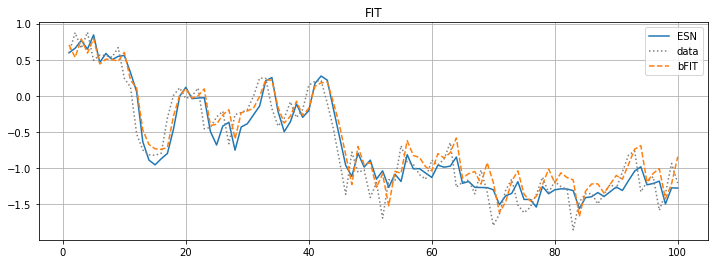

In [458]:
plt.figure(figsize=(12, 4))
plt.plot(fit['Y_fit'], label='ESN')
plt.plot(fit['Y'], label='data', color='C7', linestyle='dotted')
plt.plot(range(1, data_train_bfit.shape[0]+1), 
            data_train_bfit, label='bFIT', linestyle='dashed')  
# plt.plot(data_train[1], color='black', linestyle='dashdot')
plt.grid()
plt.legend()
plt.title("FIT")
plt.show()

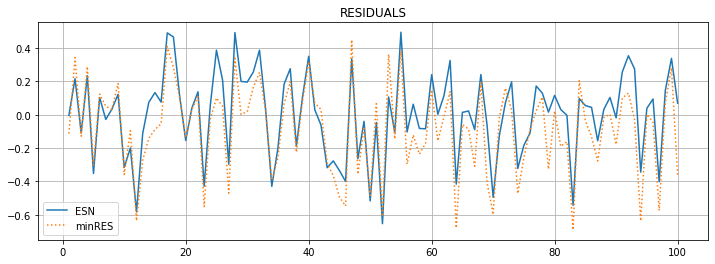

In [459]:
plt.figure(figsize=(12, 4))
plt.plot(fit['residuals'], label='ESN')
plt.plot(range(1, data_train_minres.shape[0]+1), 
            data_train_minres, label='minRES', linestyle='dotted')  
plt.grid()
plt.legend()
plt.title("RESIDUALS")
plt.show()

Cross-validation:

In [442]:
ridgecv = ridgeCV()

cvlambda = ridgecv.cv(esn, data_train, step=1, min_train_size=30, test_size=5)
cvlambda

{'model': 'ESN',
 'method': 'ridgeFit.cv',
 'cvLambda': 0.0012293112090096705,
 'result': <pymoo.core.result.Result at 0x1fb882f04f0>,
 'init': None,
 'burnin': 0}

Forecast:

In [434]:
fore = forecast(esn, data_test[0], fit)

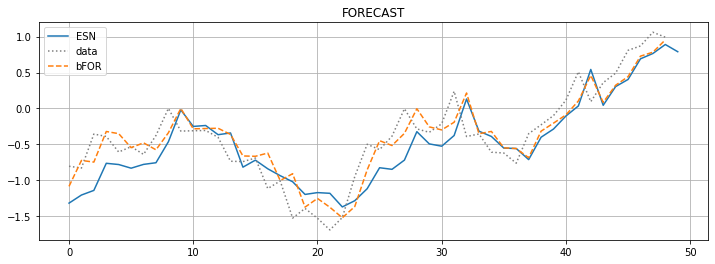

In [435]:
plt.figure(figsize=(12, 4))
plt.plot(fore['forecast'], label="ESN")
plt.plot(data_test[1], label="data", color='C7', linestyle='dotted')
plt.plot(data_test_bfor, label="bFOR", linestyle='dashed')  
plt.grid()
plt.legend()
plt.title("FORECAST")
plt.show()

##### Multi-step iterative fit

In [368]:
msfit = esn.fitMultistep(data_train, ridgeFit(0.01), steps=5, Lambda_ar=3)

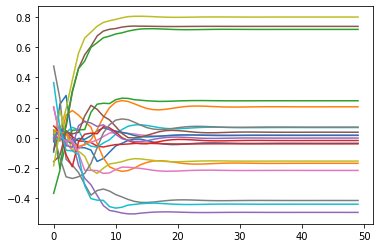

In [281]:
from LibESN.esn_states import generate, iterate_state

Xg = generate(
        states=msfit['X'][[0],:,0],
        length=50,
        W=msfit['W_ar'],
        map=esn.pars.smap, 
        A=esn.pars.A, C=esn.pars.C, zeta=esn.pars.zeta, 
        rho=esn.pars.rho, gamma=esn.pars.gamma, leak=esn.pars.leak, 
    )
plt.plot(np.squeeze(Xg[0,:,:]).T)
plt.show()

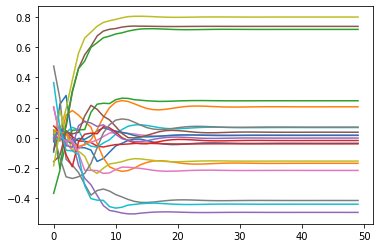

In [282]:
Xg = iterate_state(
    state=msfit['X'][0,:,0],
    length=50,
    map=esn.pars.smap, 
    A=esn.pars.A, 
    D=(esn.pars.C @ msfit['W_ar'].T), 
    zeta=esn.pars.zeta, 
    rho=esn.pars.rho, 
    gamma=esn.pars.gamma, 
    leak=esn.pars.leak, 
)
plt.plot(np.squeeze(Xg))
plt.show()

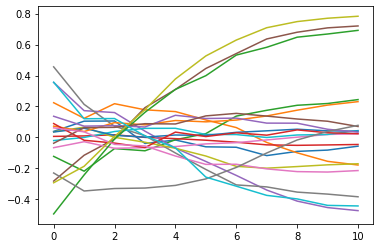

In [283]:
plt.plot(np.squeeze(msfit['X'][10,:,:]).T)
plt.show()

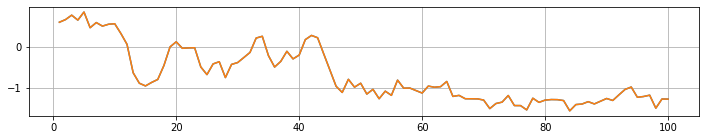

In [369]:
plt.figure(figsize=(12, 2))
plt.plot(fit['Y_fit'], label='ESN')
plt.plot(msfit['fits'][0]['Y_fit'], label=('A_fit(0)'))
plt.grid()
plt.show()

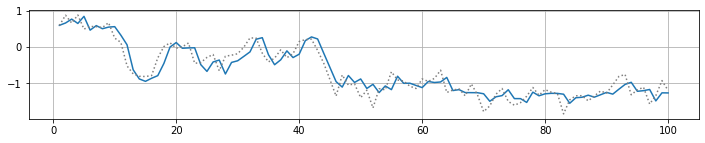

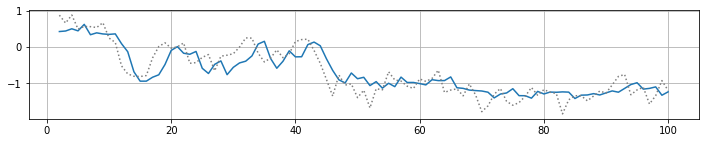

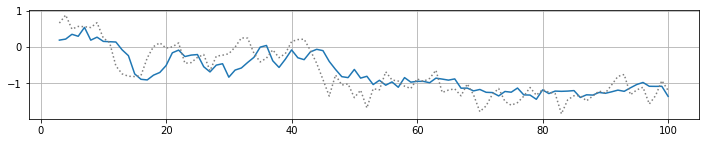

In [370]:
for i in range(3):
    plt.figure(figsize=(12, 2))
    plt.plot(msfit['fits'][i]['Y_fit'], label=('A_fit('+str(i)+')'))
    #plt.plot(data_fit_best, linestyle='dashed')  
    plt.plot(msfit['fits'][i]['Y'], color='C7', linestyle='dotted')
    plt.grid()
    plt.show()

Forecast:

In [371]:
msfore = forecastMultistep(esn, data_test[0], msfit)

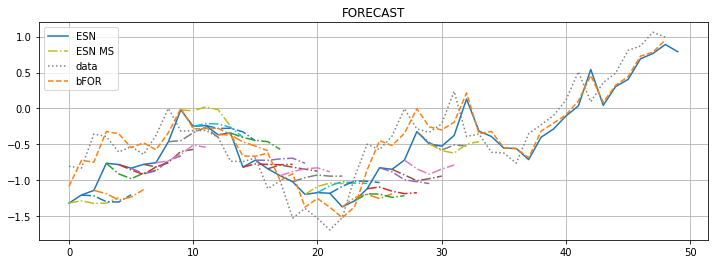

In [372]:
plt.figure(figsize=(12, 4))
plt.plot(fore['forecast'], label="ESN", color='C0')
plt.plot(msfore['forecast'][0], label="ESN MS", color='C8', ls='dashdot')
for i in range(1, 30):
    plt.plot(msfore['forecast_index'][i], msfore['forecast'][i], ls='dashdot')
    pass
plt.plot(data_test[1], label="data", color='C7', linestyle='dotted')
plt.plot(data_test_bfor, label="bFOR", linestyle='dashed', color='C1')  
plt.grid()
plt.legend()
plt.title("FORECAST")
plt.show()

##### Multi-step direct fit

In [479]:
dmsfit = esn.fitDirectMultistep(
    data_train, 
    ridgeFit([0.01, 0.02, 0.04, 0.05, 0.06]), 
    steps=5,
)

In [16]:
# dmsfit['fits'][0]['W'][0:5,]

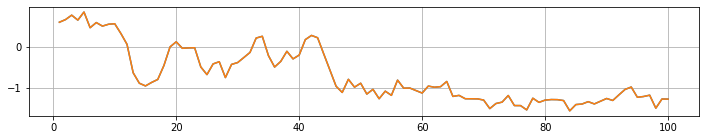

In [480]:
plt.figure(figsize=(12, 2))
plt.plot(fit['Y_fit'], label='ESN')
plt.plot(dmsfit['fits'][0]['Y_fit'], label=('A_fit(0)'))
plt.grid()
plt.show()

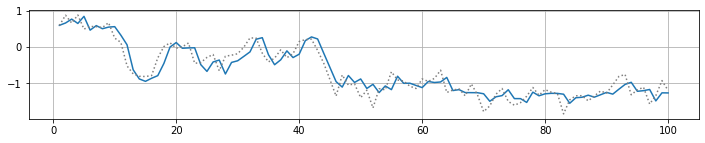

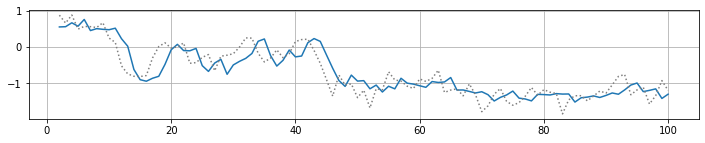

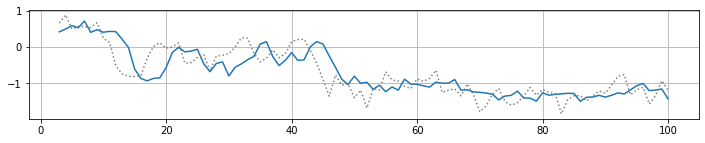

In [481]:
for i in range(3):
    plt.figure(figsize=(12, 2))
    plt.plot(dmsfit['fits'][i]['Y_fit'], label=('A_fit('+str(i)+')'))
    #plt.plot(data_fit_best, linestyle='dashed')  
    plt.plot(dmsfit['fits'][i]['Y'], color='C7', linestyle='dotted')
    plt.grid()
    plt.show()

Cross-validation:

In [482]:
ridgecv = ridgeCV()

cvlambda = ridgecv.cvDirectMultistep(esn, data_train, steps=5, min_train_size=30, test_size=5)
cvlambda

{'model': 'ESN',
 'method': 'ridgeFit.cvDirectMultistep',
 'cvLambda': [0.0012293112090096705,
  0.02218261514554926,
  0.03993397073100939,
  0.05073920255140811,
  0.06400522118764715],
 'result': [<pymoo.core.result.Result at 0x1fb89d1aca0>,
 'steps': range(1, 6),
 'init': None,
 'burnin': 0}

Forecast:

In [483]:
dmsfore = forecastDirectMultistep(esn, data_test[0], dmsfit)

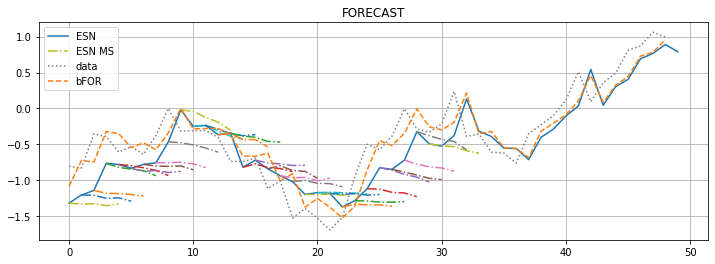

In [484]:
plt.figure(figsize=(12, 4))
plt.plot(fore['forecast'], label="ESN", color='C0')
plt.plot(dmsfore['forecast'][0], label="ESN MS", color='C8', ls='dashdot')
for i in range(1, 30):
    plt.plot(dmsfore['forecast_index'][i], dmsfore['forecast'][i], ls='dashdot')
    pass
plt.plot(data_test[1], label="data", color='C7', linestyle='dotted')
plt.plot(data_test_bfor, label="bFOR", linestyle='dashed', color='C1')  
plt.grid()
plt.legend()
plt.title("FORECAST")
plt.show()

##### Multi-step comparison

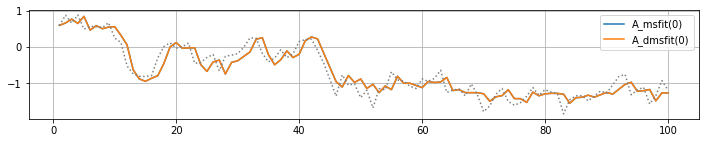

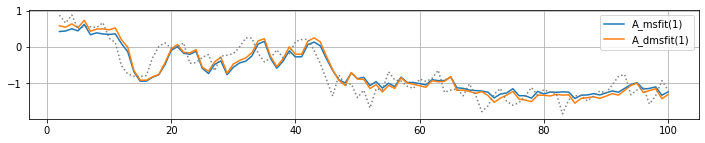

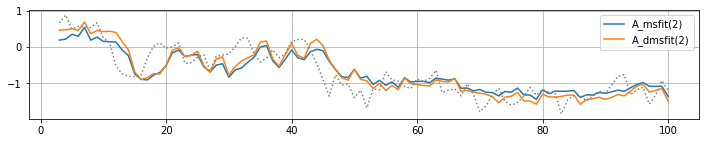

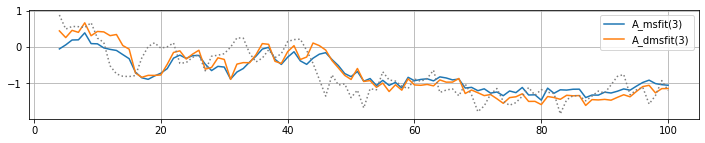

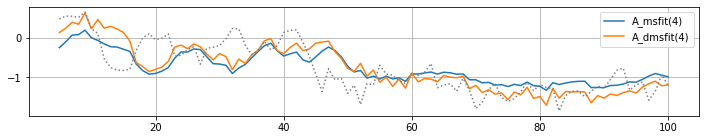

In [377]:
for i in range(5):
    plt.figure(figsize=(12, 2))
    plt.plot(msfit['fits'][i]['Y_fit'][0], label=('A_msfit('+str(i)+')'))
    plt.plot(dmsfit['fits'][i]['Y_fit'][0], label=('A_dmsfit('+str(i)+')'))
    #plt.plot(data_fit_best, linestyle='dashed')  
    plt.plot(msfit['fits'][i]['Y'][0], color='C7', linestyle='dotted')
    plt.grid()
    plt.legend()
    plt.show()